# Assignment 1
46110 Basic Aerodynamics  

s163008 Martin Simon  
s134166 Aleksander Andersen

Python Notebook

In [1]:
# Modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

## Defining helpful functions

In [31]:
def cMap(m1oc, m2oc, method, R=1, N=2**9, n_kt=2):
    """
    Function to do conformal mapping of a circle.
    
    Input:
    m1oc :: float
    m2oc :: float
    method :: 'J' or 'KT' for Joukowski or Karman-Trefftz
    R=1 :: sets the radius of the transformation circle.
    N=2**9 :: sets number of periphery points
    n_kt :: parameter for Karman-Trefftz transform
    
    Output:
    z_airfoil :: array with complex floats
    chord :: chord length
    """
    c = R/np.sqrt(m2oc**2+(1+m1oc)**2) # Transformation constant
    m1 = m1oc*c
    m2 = m2oc*c
    s = -m1 + 1j*m2 # center of circle in zeta
    
    # N points from zero to 2*pi
    angle = np.linspace(0, 2*np.pi, N)
    
    # Coord.: Circle periphery
    z_circle = R*(np.cos(angle)+1j*np.sin(angle)) + s
    
    # Coord.: Airfoil periphery
    if method == 'J':
        z_airfoil = z_circle+c**2/z_circle
    if method == 'KT':
        #z_airfoil = (z_circle-c)**n_kt * n_kt*c/( (z_circle+c)**n_kt - (z_circle-c)**n_kt )
        z_airfoil = n_kt*c*(1+((z_circle-c)/(z_circle+c))**n_kt) / (1-((z_circle-c)/(z_circle+c))**n_kt)
    
    # Chord length as the distance along the real axis.
    chord = np.max(z_airfoil.real) - np.min(z_airfoil.real)
    
    return z_airfoil, chord

$z = \left[1+\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right] \left[1-\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right]^{-1} nc$

In [32]:
def splitAirfoil(z_airfoil):
    """
    Splits airfoil periphery into upper and lower part
    and makes linear interpolation between the points.
    
    Input:
    z_airfoil :: Should be the output of the cMap function.
    
    Output:
    fu :: function for upper section
    fl :: function for lower section
    Returns
    """
    n = z_airfoil.size
    # Find index for leading and trailing edge points
    leftMostPoint = np.argmin(z_airfoil.real)
    rightMostPoint = np.argmax(z_airfoil.real)        
    
    # Splitting into upper and lower part of airfoil
    if rightMostPoint == 0:
        za_upper = z_airfoil[:leftMostPoint]
        za_lower = z_airfoil[leftMostPoint:]
    else:
        _a = z_airfoil[(rightMostPoint-n):]
        za_upper = np.concatenate((_a, z_airfoil[:leftMostPoint]))
        za_lower = z_airfoil[leftMostPoint:rightMostPoint]
    return za_upper, za_lower

In [33]:
def closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol):
    """
    Used for assessing results.
    
    Input:
    r_t :: max thickness/chord - output from for-loop
    r_c :: max camber/chord - output from for-loop
    r_m1oc :: corresponding m1oc values
    r_m2oc :: corresponding m2oc values
    camberVal :: target value (not in %)
    thickVal :: target value (not in %)
    t_tol :: tolerance value. Adjust if necessary
    h_tol :: tolerance value
    """    
    for i in range(r_t.size):
        # Looks for any camber values in target range.
        if (camberVal-h_tol) < r_c[i] <= (camberVal+h_tol):
            # Looks for any thickness valuen in target range.
            if (thickVal-t_tol) < r_t[i] <= (thickVal+t_tol):
                # If success, it will print index, values and 
                print('Point #:',i)
                print('t/chord:',r_t[i])
                print('h/chord:',r_c[i])
                print('(m1oc, m2oc) = ({0:.4f}, {1:.4f})\n'.format(r_m1oc[i], r_m2oc[i]))

# Task A
Determine $\dfrac{m_1}{c}$ and $\dfrac{m_2}{c}$ for the Joukowski airfoil with relative (to chord) thicknesses of 10%, 20% and 30% and maximum camber 0% and 10%.  
Also try to do this with the linearized approach from the book.

Numerical approach:  
Transformation: $z = \zeta+\dfrac{c^2}{\zeta}$  


Max thickness: $\dfrac{t}{chord}\bigg) _{max}$  
Max camber: $\dfrac{h}{chord}\bigg) _{max}$  
Just take thickness as be the difference in y-values so $t=y_u-y_l$  
With the camber line: $h = \dfrac{y_y+y_l}{2}$

### Linearized approach
When values of $\dfrac{m_1}{c}$ and $\dfrac{m_2}{c}$ have been determined, the linearized approach from the Curie book is used to compare the numerical (and non-linearized) approach with the linear approach.

In [34]:
def J_linear(m1oc,m2oc, R=1):
    c = R/np.sqrt(m2oc**2+(1+m1oc)**2) # Transformation constant
    m1 = m1oc*c
    m2 = m2oc*c
    chord = 4*c
    
    # Relative thickness
    t_rel = m1oc*3*np.sqrt(3)/4
    h_rel = 2*m2/chord
    
    print('Linear approach')
    print('t/chord: {:.4f}'.format(t_rel))
    print('h/chord: {:.4f}'.format(h_rel))

In [5]:
M1 = 400
M2 = 400
n_tests = int(M1*M2) # Number of tests

# Various values for m1/c and m2/c
m1oc = np.linspace(0, 0.4, M1) 
m2oc = np.linspace(0, 0.4, M2)

## Testing the different values

# Empty array to fill in
r_t = np.array([]) # max relative thickness
r_c = np.array([]) # max relative camber
r_m1oc = np.array([]) # m1oc value
r_m2oc = np.array([]) # m2oc value

# Actual testing
for i in range(M1):
    for j in range(M2):
        z_airfoil, chord = cMap(m1oc[i], m2oc[j], 'J', R=1, N=2**9)
        
        za_upper, za_lower = splitAirfoil(z_airfoil)
        
        # Interpolation functions for upper and lower airfoil curves
        fu = interpolate.interp1d(za_upper.real,za_upper.imag, kind='linear',bounds_error=False)
        fl = interpolate.interp1d(za_lower.real,za_lower.imag, kind='linear',bounds_error=False)
        
        # Limit values for interpolation.
        # Edge values are removed to avoid any errors
        lim1 = np.min( z_airfoil.real )*0.99
        lim2 = np.max( z_airfoil.real )*0.99
        # Evaluation points
        span = np.linspace(lim1,lim2,400)
        
        
        # Finding max relative thickness
        max_t = np.nanmax( (fu(span) - fl(span))/chord )
        # Max relative camber
        max_camber = np.nanmax( (fu(span)+fl(span))/2 )
        
        # Save result
        r_t = np.append(r_t, max_t)
        r_c = np.append(r_c, max_camber)
        r_m1oc = np.append(r_m1oc, m1oc[i])
        r_m2oc = np.append(r_m2oc, m2oc[j])

In [6]:
# Save data to files
np.savetxt('maxRelThickness.txt',r_t)
np.savetxt('maxRelCamber.txt',r_c)
np.savetxt('m1oc.txt',r_m1oc)
np.savetxt('m2oc.txt',r_m2oc)

In [ ]:
# If block has run, then load data
r_t = np.loadtxt('maxRelThickness.txt')
r_c = np.loadtxt('maxRelCamber.txt')
r_m1oc = np.loadtxt('m1oc.txt')
r_m2oc = np.loadtxt('m2oc.txt')

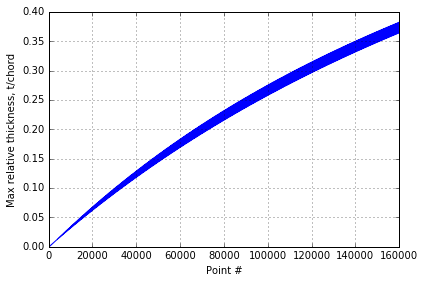

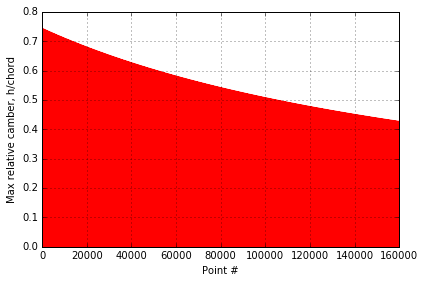

In [7]:
plt.figure()
plt.plot(r_t,'-b')
plt.xlabel('Point #')
plt.ylabel('Max relative thickness, t/chord')
plt.grid()
plt.tight_layout()
plt.savefig('01_J_rt.pdf')

plt.figure()
plt.plot(r_c,'-r')
plt.xlabel('Point #')
plt.ylabel('Max relative camber, h/chord')
plt.grid()
plt.tight_layout()
plt.savefig('02_J_rh.pdf')

### Results for part A

In [13]:
# Relative camber 0%
# Relative thickness 10%
camberVal = 0
thickVal = 0.1
t_tol = 0.0005 # Adjust
h_tol = 0.0005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

Point #: 33200
t/chord: 0.0996386002915
h/chord: 1.14491749414e-16
(m1oc, m2oc) = (0.0832, 0.0000)



In [35]:
J_linear(0.0832, 0.0000)

Linear approach
t/chord: 0.1081
h/chord: 0.0000


In [14]:
# Relative camber 0%
# Relative thickness 20%
camberVal = 0
thickVal = 0.2
t_tol = 0.0005 # Adjust
h_tol = 0.0005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

Point #: 73200
t/chord: 0.200166617079
h/chord: 1.38777878078e-16
(m1oc, m2oc) = (0.1835, 0.0000)



In [36]:
J_linear(0.1835, 0.0000)

Linear approach
t/chord: 0.2384
h/chord: 0.0000


In [15]:
# Relative camber 0%
# Relative thickness 30%
camberVal = 0
thickVal = 0.3
t_tol = 0.0005 # Adjust
h_tol = 0.0005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

Point #: 122000
t/chord: 0.30001483146
h/chord: 1.11022302463e-16
(m1oc, m2oc) = (0.3058, 0.0000)



In [37]:
J_linear(0.3058, 0.0000)

Linear approach
t/chord: 0.3972
h/chord: 0.0000


In [16]:
# Relative camber 10%
# Relative thickness 10%
camberVal = 0.1
thickVal = 0.1
t_tol = 0.0005 # Adjust
h_tol = 0.0005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

Point #: 33258
t/chord: 0.0998509566203
h/chord: 0.0995523772563
(m1oc, m2oc) = (0.0832, 0.0581)



In [38]:
J_linear(0.0832, 0.0581)

Linear approach
t/chord: 0.1081
h/chord: 0.0290


In [17]:
# Relative camber 10%
# Relative thickness 20%
camberVal = 0.1
thickVal = 0.2
t_tol = 0.0005 # Adjust
h_tol = 0.0005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

Point #: 72868
t/chord: 0.199723133642
h/chord: 0.0997213705218
(m1oc, m2oc) = (0.1825, 0.0682)



In [39]:
J_linear(0.1825, 0.0682)

Linear approach
t/chord: 0.2371
h/chord: 0.0341


In [29]:
# Relative camber 10%
# Relative thickness 30%
camberVal = 0.1
thickVal = 0.3
t_tol = 0.0001 # Adjust
h_tol = 0.0006 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

Point #: 121680
t/chord: 0.300040775386
h/chord: 0.0994673037994
(m1oc, m2oc) = (0.3048, 0.0802)



In [40]:
J_linear(0.3048, 0.0802)

Linear approach
t/chord: 0.3959
h/chord: 0.0401


# Task A - Linearized Approach

# Task B
Karman-Trefftz transformation.  
$\dfrac{z-nc}{z+nc} = \left(\dfrac{\zeta-c}{\zeta+c}\right)^n$  


$z = \left(\dfrac{\zeta-c}{\zeta+c}\right)^n z + \left(\dfrac{\zeta-c}{\zeta+c}\right)^n nc + nc$

$z = \left(\dfrac{\zeta-c}{\zeta+c}\right)^n z
+\left[1+\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right] nc$  
$z \left[1-\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right] = \left[1+\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right] nc$

$z = \left[1+\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right] \left[1-\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right]^{-1} nc$

$z = \dfrac{\left[1+\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right]}{\left[1-\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right]}nc$

B.1  
Karman-Trefftz transformation for trailing edge angle $\beta$ = 18°.  
$\beta=2\pi-n\pi \leftrightarrow n=2-\beta/\pi$

In [ ]:
## INPUTS
betad = 18 # trailing edge angle [deg]

M1 = 80 # points for m1oc
M2 = 80 # points for m2oc
n_tests = int(M1*M2) # Number of tests

beta = betad*np.pi/180
n_kt = 2-beta/np.pi 
print('Kármán-Trefftz parameter for 18° trailing edge angle \nn= {:.2f}'.format(n_kt))


# Various values for m1/c and m2/c
m1oc = np.linspace(0, 0.32, M1) 
m2oc = np.linspace(0, 0.32, M2)

## Testing the different values
# Empty array to fill in
r_t = np.array([]) # max relative thickness
r_c = np.array([]) # max relative camber
r_m1oc = np.array([]) # m1oc value
r_m2oc = np.array([]) # m2oc value

#fig1,ax1 = plt.subplots()
#fig2,ax2 = plt.subplots()

# Actual testing
for i in range(M1):
    for j in range(M2):
        # Calculates airfoil and chord
        z_airfoil, chord = cMap(m1oc[i], m2oc[j], 'KT', R=1, N=2**9, n_kt=n_kt)
        
        # Splits in upper and lower
        za_upper, za_lower = splitAirfoil(z_airfoil)

        # Makes interpolation functions for upper and lower airfoil curve
        fu = interpolate.interp1d(za_upper.real,za_upper.imag, kind='linear',bounds_error=False)
        fl = interpolate.interp1d(za_lower.real,za_lower.imag, kind='linear',bounds_error=False)
        
        # Limit values for interpolation.
        # Edge values are removed to avoid any errors
        lim1 = np.min( z_airfoil.real )*0.99
        lim2 = np.max( z_airfoil.real )*0.99
        # Evaluation points
        span = np.linspace(lim1,lim2,400)
        
        
        # Finding max relative thickness
        max_t = np.nanmax( (fu(span) - fl(span))/chord )
        # Finding max relative camber
        max_camber = np.nanmax( (fu(span)+fl(span))/2 )
        
        # Save result in array
        r_t = np.append(r_t, max_t)
        r_c = np.append(r_c, max_camber)
        r_m1oc = np.append(r_m1oc, m1oc[i])
        r_m2oc = np.append(r_m2oc, m2oc[j])
        
        # Plotting
        
        #if i%2==0 and j%2==0:
            #ax1.plot(z_circle.real, z_circle.imag,'-')
            #ax1.set_aspect('equal')
            #ax2.plot(z_airfoil.real, z_airfoil.imag,'-',label=[i,j])
            #ax2.set_aspect('equal')
            
            # X-Y limits for zooming in on trailing edge
            #ax2.set_xlim(-0.01,0.01)
            #ax2.set_ylim(-0.01,0.01)

In [ ]:
# Save data to files
np.savetxt('kt_maxRelThickness.txt',r_t)
np.savetxt('kt_maxRelCamber.txt',r_c)
np.savetxt('kt_m1oc.txt',r_m1oc)
np.savetxt('kt_m2oc.txt',r_m2oc)

In [ ]:
plt.figure()
plt.plot(r_t,'-b')
plt.xlabel('Point #')
plt.ylabel('Max relative thickness, t/chord')
plt.grid()
plt.tight_layout()
plt.savefig('01_J_rt.pdf')

plt.figure()
plt.plot(r_c,'-r')
plt.xlabel('Point #')
plt.ylabel('Max relative camber, h/chord')
plt.grid()
plt.tight_layout()
plt.savefig('02_J_rh.pdf')

### Results for part B

In [ ]:
# Relative camber 0%
# Relative thickness 10%
camberVal = 0
thickVal = 0.1
t_tol = 0.005 # Adjust
h_tol = 0.00001 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

In [ ]:
# Relative camber 0%
# Relative thickness 20%
camberVal = 0
thickVal = 0.2
t_tol = 0.005 # Adjust
h_tol = 0.005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

In [ ]:
# Relative camber 0%
# Relative thickness 30%
camberVal = 0
thickVal = 0.3
t_tol = 0.0005 # Adjust
h_tol = 0.0001 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

In [ ]:
# Relative camber 10%
# Relative thickness 10%
camberVal = 0.1
thickVal = 0.1
t_tol = 0.005 # Adjust
h_tol = 0.005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

In [ ]:
# Relative camber 10%
# Relative thickness 10%
camberVal = 0.1
thickVal = 0.2
t_tol = 0.0005 # Adjust
h_tol = 0.0005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

In [ ]:
# Relative camber 10%
# Relative thickness 30%
camberVal = 0.1
thickVal = 0.1
t_tol = 0.0005 # Adjust
h_tol = 0.0005 # Adjust
closestVal(r_t,r_c, r_m1oc,r_m2oc, thickVal,camberVal, t_tol, h_tol)

# Task C
Contour plotting

In [ ]:
# J

In [ ]:

# Print and plot if within tolerance.
ind = np.argmax((fu(span) - fl(span))/chord) # index in span
print('trel: {0:.5f} - m/c= ({1:.3f}, {2:.3f})'.format(max_trel, m1oc[i], m2oc[j]))
plt.plot(span,fu(span),'.-b')
plt.plot(span,fl(span),'.-r')
plt.plot(span[ind],fu(span[ind]),'ro',ms=5)
plt.plot(span[ind],fl(span[ind]),'bo',ms=5)

In [ ]:
g = np.linspace(0,10,11,endpoint=True)
print(g)

In [ ]:
g[::1]

In [ ]:
np.hstack(([5],[2,3]))

In [ ]:
z_airfoil

In [ ]:
z_airfoil.real

In [ ]:
np.argmin(z_airfoil.real)

In [ ]:
np.argmax(z_airfoil.real)

In [ ]:
angle

In [ ]:
g[-5:]

In [ ]:
g.size

In [ ]:
g[4:]

In [ ]:
g[(9-11+2):]

In [ ]:
g[5]

In [ ]:
h = np.array([11,11,11])

In [ ]:
h

In [ ]:
g

In [ ]:
np.concatenate((g,h))

In [ ]:
_a